In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
confusion_matrix,precision_recall_curve, roc_auc_score, roc_curve, auc, classification_report 

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# For standardization
from sklearn.preprocessing import StandardScaler

# Helper for cross-validation
from sklearn.model_selection import GridSearchCV

# Logistic regression
from sklearn.linear_model import LogisticRegression

# Ensemble methods
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

#SVM
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

### Create different functions for further use

In [3]:
def auroc_curves(fitted_models):
    # Calculate ROC curve from y_test and pred
    for name, model in fitted_models.items():
        fpr, tpr, thresholds = roc_curve(y_test, fitted_models[name].predict_proba(X_test)[:,1])
        #auc_roc = auc(fpr, tpr) - the same as roc_auc_score(y_test, fitted_models[name].predict_proba(X_test)[:,1])
        auc_roc = roc_auc_score(y_test, fitted_models[name].predict_proba(X_test)[:,1])
        plt.figure()
        plt.grid(True)
        plt.plot(fpr, tpr, label = name + ' (AUC = %0.3f)' % auc_roc)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic ' + name)
        plt.legend(loc="lower right")
        #plt.savefig('Log_ROC')
        plt.show()

def conf_matrix(fitted_models):
    # Print confusion matrix
    for name, model in fitted_models.items():
        y_pred_test = fitted_models[name].predict(X_test)
        cm = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
        print(name)
        print("Recall: ", 100*round(recall_score(y_pred=y_pred_test, y_true=y_test),2))
        print("Precision: ", 100*round(precision_score(y_pred=y_pred_test, y_true=y_test),2))
        cm_print(cm, name)

def cm_decision(fitted_models, p):
    # Print confusion matrix for specified probability p
    for name, model in fitted_models.items():
        y_pred_proba = fitted_models[name].predict_proba(X_test)[:,1]
        y_pred_test = (y_pred_proba >= p).astype('int')
        cm = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
        print(name)
        print("Recall: ", 100*round(recall_score(y_pred=y_pred_test, y_true=y_test),2))
        print("Precision: ", 100*round(precision_score(y_pred=y_pred_test, y_true=y_test),2))
        cm_print(cm, name)

        
def cm_print(cm, name):
    # Print colored confusion matrix
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.tab20)
    classNames = ['Churn', 'Retain']
    plt.title('Customer Churn Confusion Matrix - ' + name)
    plt.ylabel('TRUE')
    plt.xlabel('PREDICTED')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    plt.grid()
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), ha= 'center', va= 'center')
    plt.show()
    
def best_score(fitted_models):
    # Display best_score_ for each fitted model
    for name, model in fitted_models.items():
        print(name, model.best_score_ )

def print_metrics(fitted_models):
    for name, model in fitted_models.items():
        # Store metrics
        y_pred_test = fitted_models[name].predict(X_test)
        metrics.loc['accuracy', name] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
        metrics.loc['precision', name] = precision_score(y_pred=y_pred_test, y_true=y_test)
        metrics.loc['recall', name] = recall_score(y_pred=y_pred_test, y_true=y_test)
    return 100 * metrics

def rec_prec_plot(fitted_models):
    # Recall vs precision plot
    prt = {}
    fig, ax = plt.subplots(figsize=(8,5))
    
    for k in fitted_models.keys():
        prt[k] = precision_recall_curve(y_true=y_test, probas_pred=fitted_models[k].predict_proba(X_test)[:,1])
        ax.plot(prt[k][0], prt[k][1], label = k)

    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    ax.set_title('Recall vs Precision')
    ax.legend()
    ax.grid(True)

def metrics_plot(metrics):
    fig, ax = plt.subplots(figsize=(8,5))
    metrics.plot(kind='barh', ax=ax)
    ax.grid(True)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Create dictionaries and lists

In [5]:
# Dictionaries and lists for further conversion and renaming of dataframe columns
online_serv_dict = {'OnlineSecurity':'OS', 'OnlineBackup':'OB',
             'DeviceProtection':'DP', 'TechSupport':'TS', 'StreamingTV':'STV', 'StreamingMovies':'STM'}

internet_serv = ['DSL', 'Fiber optic', 'No']

psml = ['PhoneService', 'MultipleLines']
pm_dict = {'Bank transfer (automatic)':'BT', 'Credit card (automatic)':'CC', 'Electronic check':'EC',
           'Mailed check':'MC'}
contract_dict = {'Month-to-month':'MM', 'One year':'1Y', 'Two year':'2Y'}

In [6]:
### Correct total charges value
def correct_total_charges(df):
    df['TotalCharges'] = df['TotalCharges'].apply(lambda x: '0' if x == ' ' else x)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
    
    # Find all tenure values < 1 and set TotalCharges = MonthlyCharges
    df.loc[df['tenure'] < 1, 'TotalCharges'] = df[df['tenure'] < 1]['MonthlyCharges']
    
    df['TotalCharges'] = df['TotalCharges'].apply(lambda x: round(x))
    
    # Set tenure values < 1 to 1
    df['tenure'] = df['tenure'].apply(lambda x: 1 if x < 1 else x)

### Rename internet services
def rename_internet_serv(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: 0 if x =='No' else (1 if x == 'DSL' else 2))

### Rename online services
def rename_online_serv(df, online_serv_dict):
    for k, v in online_serv_dict.items():
        # 'No internet service' is the same as 'No' for all online services
        df[v] = df[v].apply(lambda x: 0 if x == 'No internet service' else (0 if x == 'No' else 1))

### Rename PSTN services        
def rename_pstn_serv(df, psml):
    df[psml[0]] = df[psml[0]].apply(lambda x: 0 if x == 'No' else 1)
    df[psml[1]] = df[psml[1]].apply(lambda x: -1 if x == 'No phone service' else(0 if x == 'No' else 1))
    df['PSML'] = df[psml].sum(axis = 1)
    # to string, for dummy variables
    df['PSML'] = df['PSML'].apply(lambda x: str(x))
        
### Create intervals of values
        
def set_interval(x, n_intervals_dict):
    for k in n_intervals_dict.keys():
        if x in n_intervals_dict[k]:
            return k 

def convert_to_intervals(df, col_name, intervals_arr, int_name):
    bins = intervals_arr
    intervals_a = [pd.Interval(left=bins[i], right=bins[i+1], closed = 'right') for i in range(len(bins) - 1)]
    n_intervals_dict = dict(zip(range(1, len(bins)), intervals_a))
    #print(n_intervals_dict)
    df[col_name] = df[col_name].apply(lambda x: int_name + str(set_interval(x, n_intervals_dict)))

########################################################################################################    

### Impute missed values
def impute(df, tc):
    #Impute mean values instead of missed values
    df[tc] = df[tc].apply(lambda x: df[tc].mean() if x == 0 else x)

### Rename values
def rename_vals(x, pm_dict):
    for k, v in pm_dict.items():
        if x == k:
            return v
            
### Assign numeric values to Payment method
def payment_method(df, pm_dict):
    df['PaymentMethod'] = df['PaymentMethod'].apply(lambda x: rename_vals(x, pm_dict))
    df['PaymentMethod'] = df['PaymentMethod'].apply(lambda x: -1 if x == 'EC' else (0 if x=='CC' else 1))


### Rename contract types
def rename_contract(df):
    df['Contract'] = df['Contract'].apply(lambda x: rename_vals(x, contract_dict))
    

### Process other columns of a dataframe
def process_columns(df):
    df['Churn'] = df['Churn'].apply(lambda x: 0 if x == 'No' else 1)
    df['gender'] = df['gender'].apply(lambda x: 0 if x == 'Female' else 1)
    df['Partner'] = df['Partner'].apply(lambda x: 0 if x == 'No' else 1)
    df['Dependents'] = df['Dependents'].apply(lambda x: 0 if x == 'No' else 1)
    df['PaperlessBilling'] = df['PaperlessBilling'].apply(lambda x: 0 if x == 'No' else 1)
    df['SDGP'] = df['SeniorCitizen'] + df['Dependents'] + df['gender'] + \
                 df['Partner'] + df['PaymentMethod']
        
    df['DTMC'] = df['TotalCharges'] / df['MonthlyCharges']

In [7]:
correct_total_charges(df)

df.rename(index = str, columns = online_serv_dict, inplace=True)

rename_online_serv(df, online_serv_dict)

rename_pstn_serv(df, psml)

rename_contract(df)

payment_method(df, pm_dict)

process_columns(df)

In [8]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OS',
       'OB', 'DP', 'TS', 'STV', 'STM', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'PSML',
       'SDGP', 'DTMC'],
      dtype='object')

In [9]:
df['PMPB'] = df['PaymentMethod'] + df['PaperlessBilling'] + df['Partner']
df['SDG'] = df['SeniorCitizen'] + df['Dependents'] + df['gender']

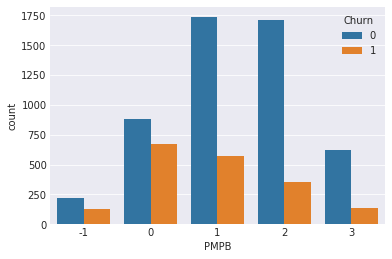

In [10]:
sns.set_style(style='darkgrid')
sns.countplot(x = 'PMPB', data = df, hue = 'Churn')

In [11]:
df['PMPB'] = df['PMPB'].apply(lambda x: 0 if x == -1 else (2 if x == 3 else x))

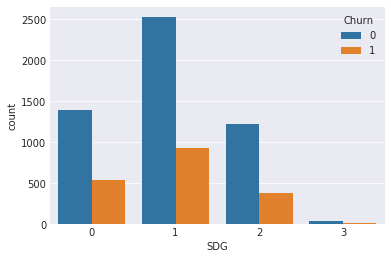

In [12]:
sns.countplot(x = 'SDG', data = df, hue = 'Churn')

In [13]:
### Merge SDG == 2 and SDG == 3
df['SDG'] = df['SDG'].apply(lambda x: 2 if x == 3 else x)

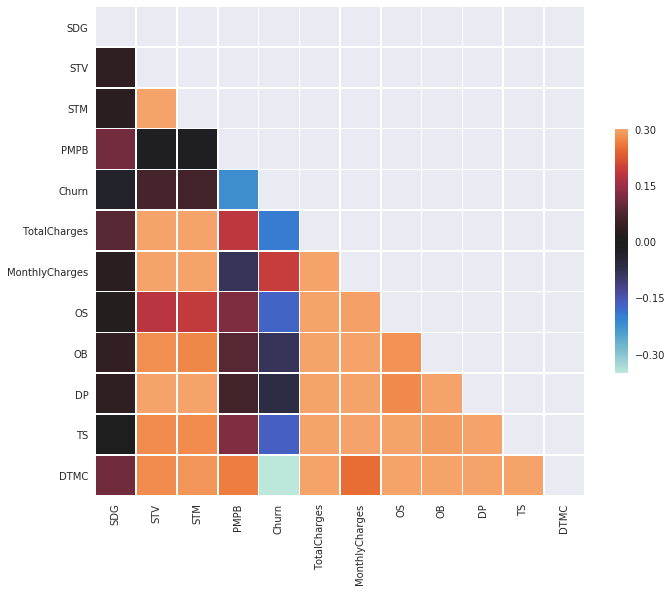

In [14]:
sns.set(style="dark")

corr = df[['SDG', 'STV', 'STM', 'PMPB', 'Churn', 'TotalCharges', 'MonthlyCharges','OS',
           'OB', 'DP', 'TS', 'DTMC']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask = mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [15]:
tenure_int = np.array([0, 3, 6, 9, 12, 18, 24, 36, 48, 60, 72])
convert_to_intervals(df, 'tenure', tenure_int, 'int_')

In [16]:
df.drop('customerID', axis=1, inplace = True)
df = pd.get_dummies(df, drop_first = True)

In [17]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'OS', 'OB', 'DP', 'TS', 'STV', 'STM',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'SDGP', 'DTMC', 'PMPB', 'SDG', 'tenure_int_10', 'tenure_int_2',
       'tenure_int_3', 'tenure_int_4', 'tenure_int_5', 'tenure_int_6',
       'tenure_int_7', 'tenure_int_8', 'tenure_int_9',
       'InternetService_Fiber optic', 'InternetService_No', 'Contract_2Y',
       'Contract_MM', 'PSML_1', 'PSML_2'],
      dtype='object')

In [18]:
df.drop(['PhoneService','SeniorCitizen', 'Dependents', 'gender',
         'MultipleLines', 'MonthlyCharges', 'TotalCharges', 'Partner', 
         'PaymentMethod', 'PaperlessBilling'], axis = 1, inplace=True)

In [19]:
df.columns

Index(['OS', 'OB', 'DP', 'TS', 'STV', 'STM', 'Churn', 'SDGP', 'DTMC', 'PMPB',
       'SDG', 'tenure_int_10', 'tenure_int_2', 'tenure_int_3', 'tenure_int_4',
       'tenure_int_5', 'tenure_int_6', 'tenure_int_7', 'tenure_int_8',
       'tenure_int_9', 'InternetService_Fiber optic', 'InternetService_No',
       'Contract_2Y', 'Contract_MM', 'PSML_1', 'PSML_2'],
      dtype='object')

In [20]:
target_name = 'Churn'
X = df.drop('Churn',  axis=1)
feature_names = X.columns
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=118, stratify=df['Churn'])

In [21]:

pipelines = {'LR' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=118)),
             'BG' : make_pipeline(StandardScaler(), BaggingClassifier(random_state=118)),
             'GB' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=118)),
             'RF' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=118)),
            }

metrics = pd.DataFrame(index=['accuracy', 'precision' ,'recall'], 
                      columns=['LR', 'BG', 'RF', 'GB'])

In [22]:
# Logistic Regression hyperparameters
logreg_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 10, 10),
}

In [23]:
# Bagging hyperparameters
log_reg_bg = LogisticRegression()
dec_tree_clas = DecisionTreeClassifier()
dec_tree_clas_list = []
for j in [50, 100, 200, 500]:
    dec_tree_clas_list.append(DecisionTreeClassifier(max_features = None, max_leaf_nodes = j))
dec_tree_clas_list.append(log_reg_bg)

bg_hyperparameters = {
    'baggingclassifier__base_estimator' : dec_tree_clas_list,
    'baggingclassifier__n_estimators' : [10, 20, 50],
    'baggingclassifier__max_samples' : [0.5, 1.0],
    'baggingclassifier__max_features' : [0.5, 1.0],
    'baggingclassifier__bootstrap' : [True, False],
    'baggingclassifier__bootstrap_features': [True, False]
}


In [24]:
#Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [10, 20, 50, 100],
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 0.33],
    'randomforestclassifier__max_depth' : [10, 20, 50, 100]
}

In [25]:
# Boosted Tree hyperparameters
gb_hyperparameters = {
     'gradientboostingclassifier__n_estimators' : [20, 50, 100, 200],
     'gradientboostingclassifier__learning_rate': [0.01, 0.1, 1],
     'gradientboostingclassifier__max_depth': [10, 20, 30]
}

In [26]:
# Create hyperparameters dictionary

hyperparameters = {'LR' : logreg_hyperparameters, 'BG' : bg_hyperparameters,
                   'RF' : rf_hyperparameters, 'GB' : gb_hyperparameters}

In [27]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

LR has been fitted.
BG has been fitted.
GB has been fitted.
RF has been fitted.


In [28]:
# Print metrics for all of the models
print_metrics(fitted_models)

,LR,BG,RF,GB
accuracy,81.844,82.5532,80.5674,78.2979
precision,69.5364,71.3333,66.4474,61.3333
recall,56.1497,57.2193,54.0107,49.1979


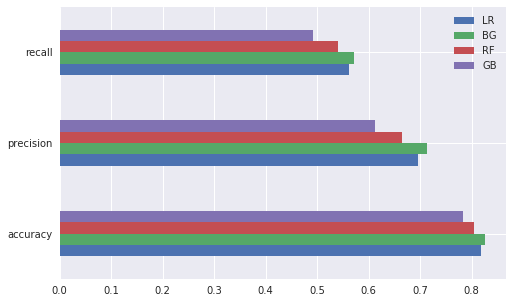

In [29]:
# Plot all metrics on single plot
metrics_plot(metrics)

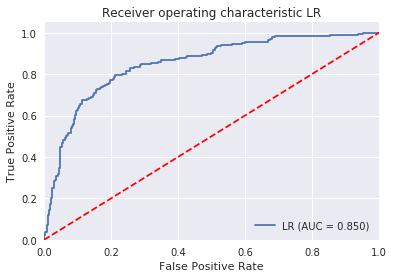

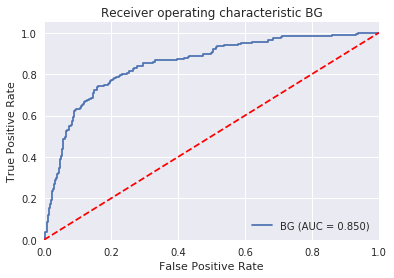

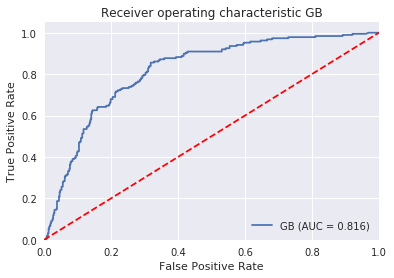

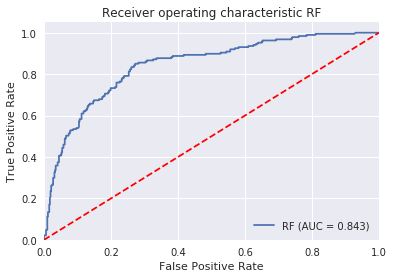

In [30]:
# Plot TPR(FPR) curves and AUROC values
auroc_curves(fitted_models)

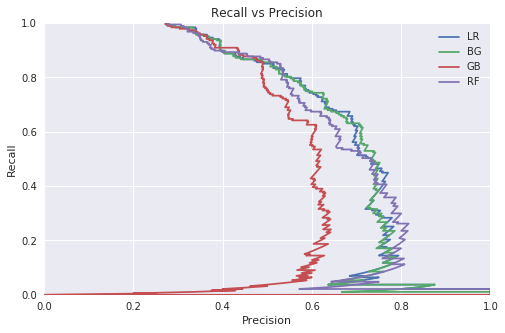

In [31]:
#plot recall vs precision curves
rec_prec_plot(fitted_models)

LR
Recall:  56.0
Precision:  70.0


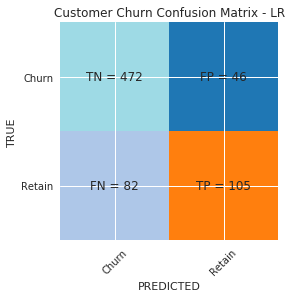

BG
Recall:  57.0
Precision:  71.0


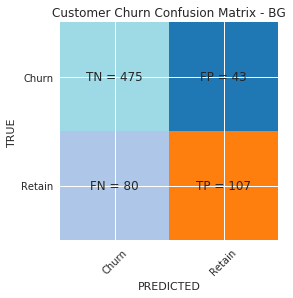

GB
Recall:  49.0
Precision:  61.0


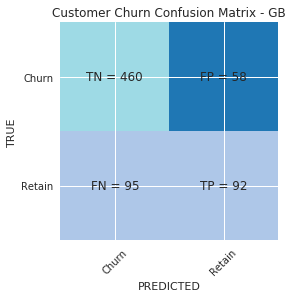

RF
Recall:  54.0
Precision:  66.0


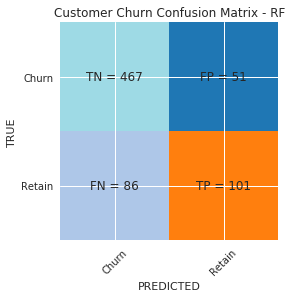

In [32]:
# Draw confusion matrices
conf_matrix(fitted_models)

LR
Recall:  87.0
Precision:  46.0


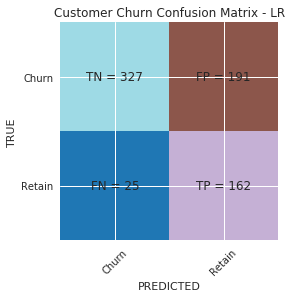

BG
Recall:  87.0
Precision:  46.0


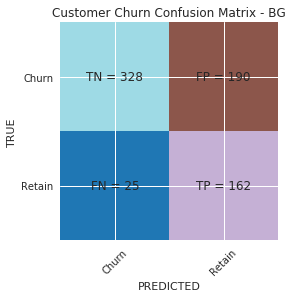

GB
Recall:  86.0
Precision:  49.0


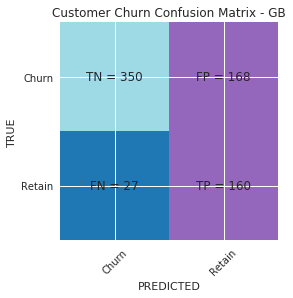

RF
Recall:  89.0
Precision:  45.0


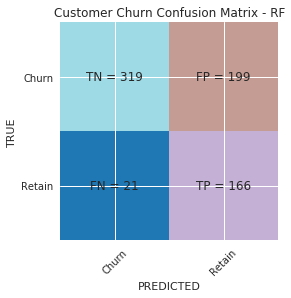

In [33]:
# Move desision border to 0.2
cm_decision(fitted_models, 0.2)